In [1]:
import os
import numpy as np
import pandas as pd
import sys
import joblib
sys.path.append('..')
from general_utils.helper import get_config


In [2]:
conf = get_config()
# class_names = conf['common_cols']['class_names'].split(',')
data_dir = conf['model_path']['out_model_dir']
# cls_names = [class_names[1],class_names[0]]  # label 0: benign, 1: LU
# # class_names[1] = benign


In [3]:
# get dataset
data_path = os.path.join(conf['out_dir']['out_root_dir'], conf['out_dir']['train_test_data_fname'])
o_data_df = pd.read_csv(data_path, sep='\t')
o_data_df.head()


,CIDEB:NM_001318807:chr14:24780583:cov,CIDEB:NM_014430:chr14:24780576:cov,DBNDD1:NM_024043:chr16:90076529:cov,ELOA3B:NM_001100817:chr18:44550298:cov,EPN2-AS1:NR_048576:chr17:19209574:cov,GCHFR:NM_005258:chr15:41056284:cov,GDA:NM_001242505:chr9:74764266:cov,GRIN2A:NM_001134407:chr16:10276263:cov,HERC2P11:NR_145479:chr15:28834386:cov,KCTD1:NM_001136205:chr18:24129399:cov,...,average_quality,error_rate,P_MAD,chrM_fraction,LENGTH_ESTIMATE,fregmentlength_cumulativefraction,Maf0.1,label,stage,stage_val
0,41.919759,41.919759,51.319981,542.763721,128.413910,118.236158,112.059801,88.332981,63.082588,99.914351,...,35.1,0.005487,0.0000,0.000009,0.404400,0.139544,0.063328,0,X,0
1,80.489344,81.495461,189.650971,534.930777,405.307562,196.491935,209.609887,89.239311,187.840873,200.445863,...,35.2,0.005658,0.0151,0.000007,0.527586,0.176473,0.067412,1,IIIA,3
2,105.506737,105.506737,185.169603,347.711262,240.548974,116.125114,137.374341,79.657368,56.129184,87.037476,...,35.3,0.005224,0.0009,0.000014,0.445151,0.154258,0.064234,0,X,0
3,121.083116,121.083116,203.529592,344.555655,68.028074,92.483205,286.023942,33.854056,170.159224,192.520993,...,35.2,0.005661,0.0000,0.000011,0.475976,0.137182,0.065834,1,IVA,4
4,44.574870,44.574870,168.497894,166.412926,109.024737,111.742952,75.846607,72.707756,34.827249,77.702247,...,35.2,0.005522,0.0006,0.000009,0.437817,0.135539,0.067881,0,X,0


In [5]:
o_data_df['stage'].value_counts()

IA      65
X       57
IB      17
IIIA    11
IIA      6
IIB      5
IIIB     3
IVB      3
IVA      1
Name: stage, dtype: int64

# split training

The model was trained using training data, and evaluated using testing data. The training data and testing data was split by all data set.

The processes of model traing and data split were done in ../model_train.py with args "split_train"

In [6]:
# load testing data set
tt_data_fname = os.path.join(data_dir, conf['model_path']['model_split_train_test_data'])
tt_data = np.load(tt_data_fname)
x_test, y_test = tt_data['x_test'], tt_data['y_test']

In [7]:
# load feature selection
sel_feat_fname = os.path.join(data_dir, conf['model_path']['model_split_select_feature_results'])
sel_feats_f = np.load(sel_feat_fname)
raw_feats, sel_supp = sel_feats_f['original_feat'], sel_feats_f['supp']

# new test data after feature selection
x_test_new = x_test[:, sel_supp]

In [8]:
# load model
model_fname = os.path.join(data_dir, conf['model_path']['model_split_model_dump_file'])
clf = joblib.load(model_fname)

In [9]:
p_pred_prob = clf.predict_proba(x_test_new)

In [10]:
p_pred_lab = clf.predict(x_test_new)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [13]:
classes=[0, 1, 2, 3, 4]
y_val = label_binarize(y_test, classes=classes)
n_classes = len(classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], p_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), p_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



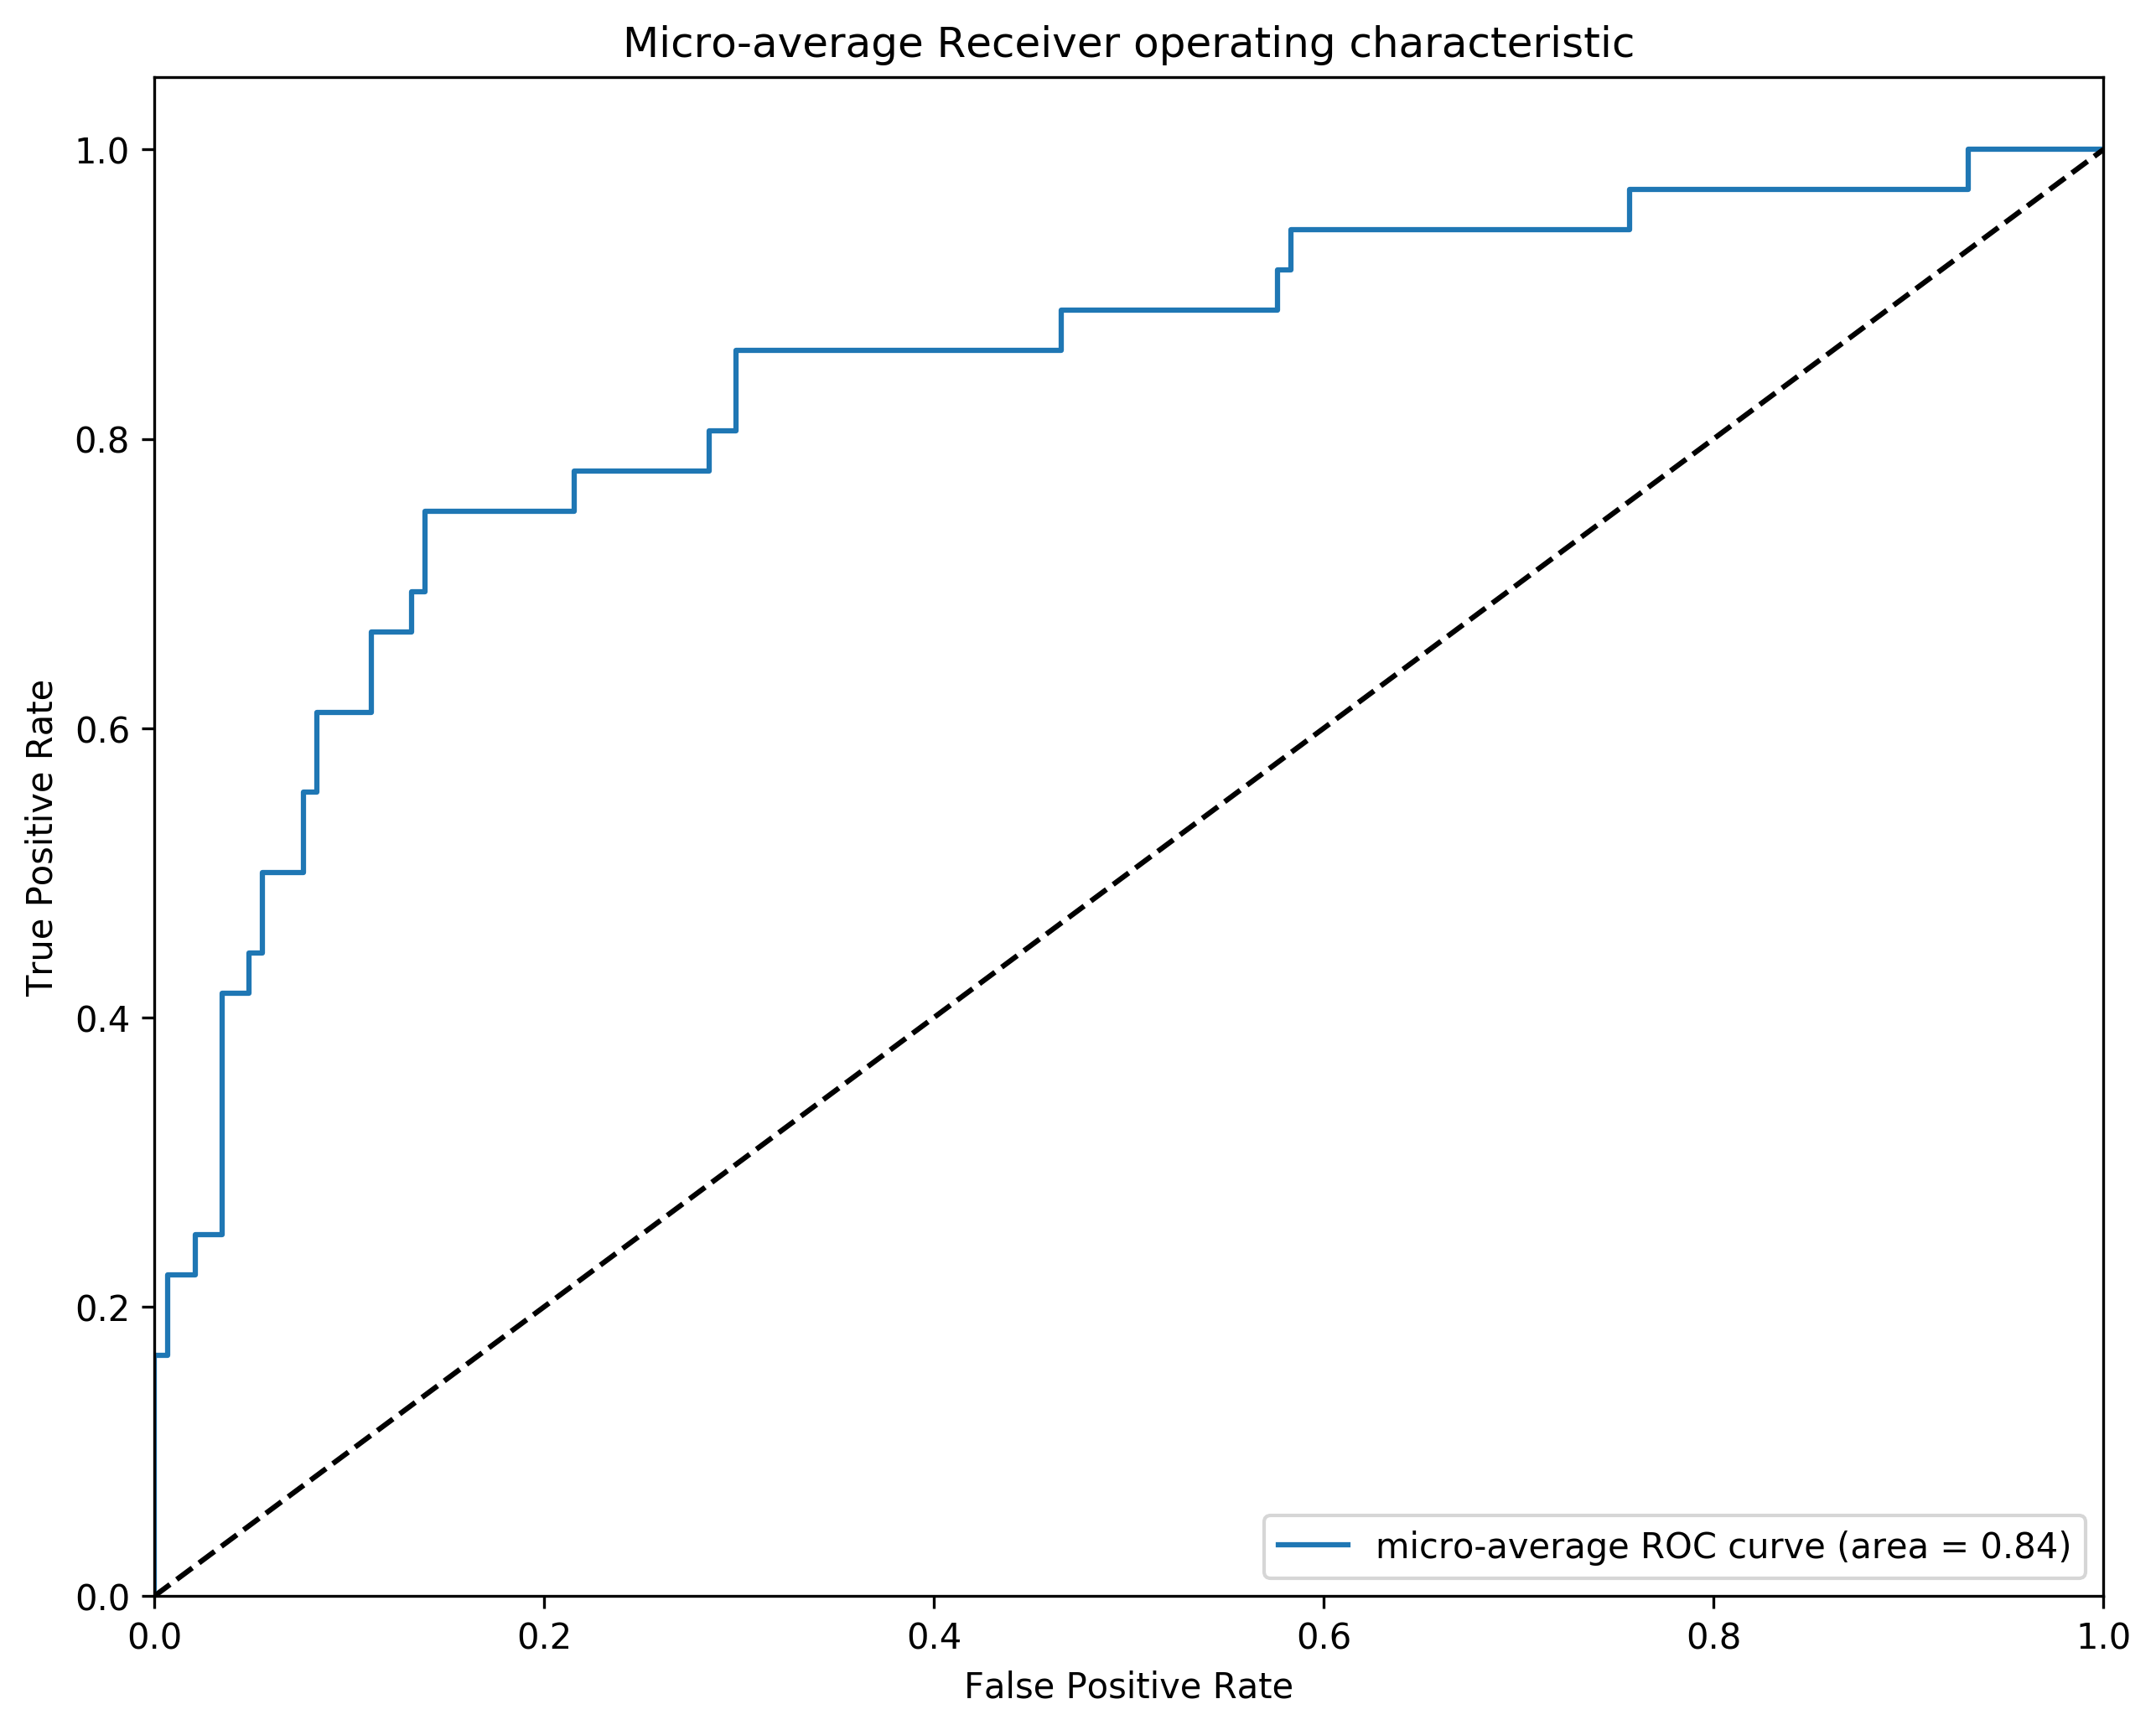

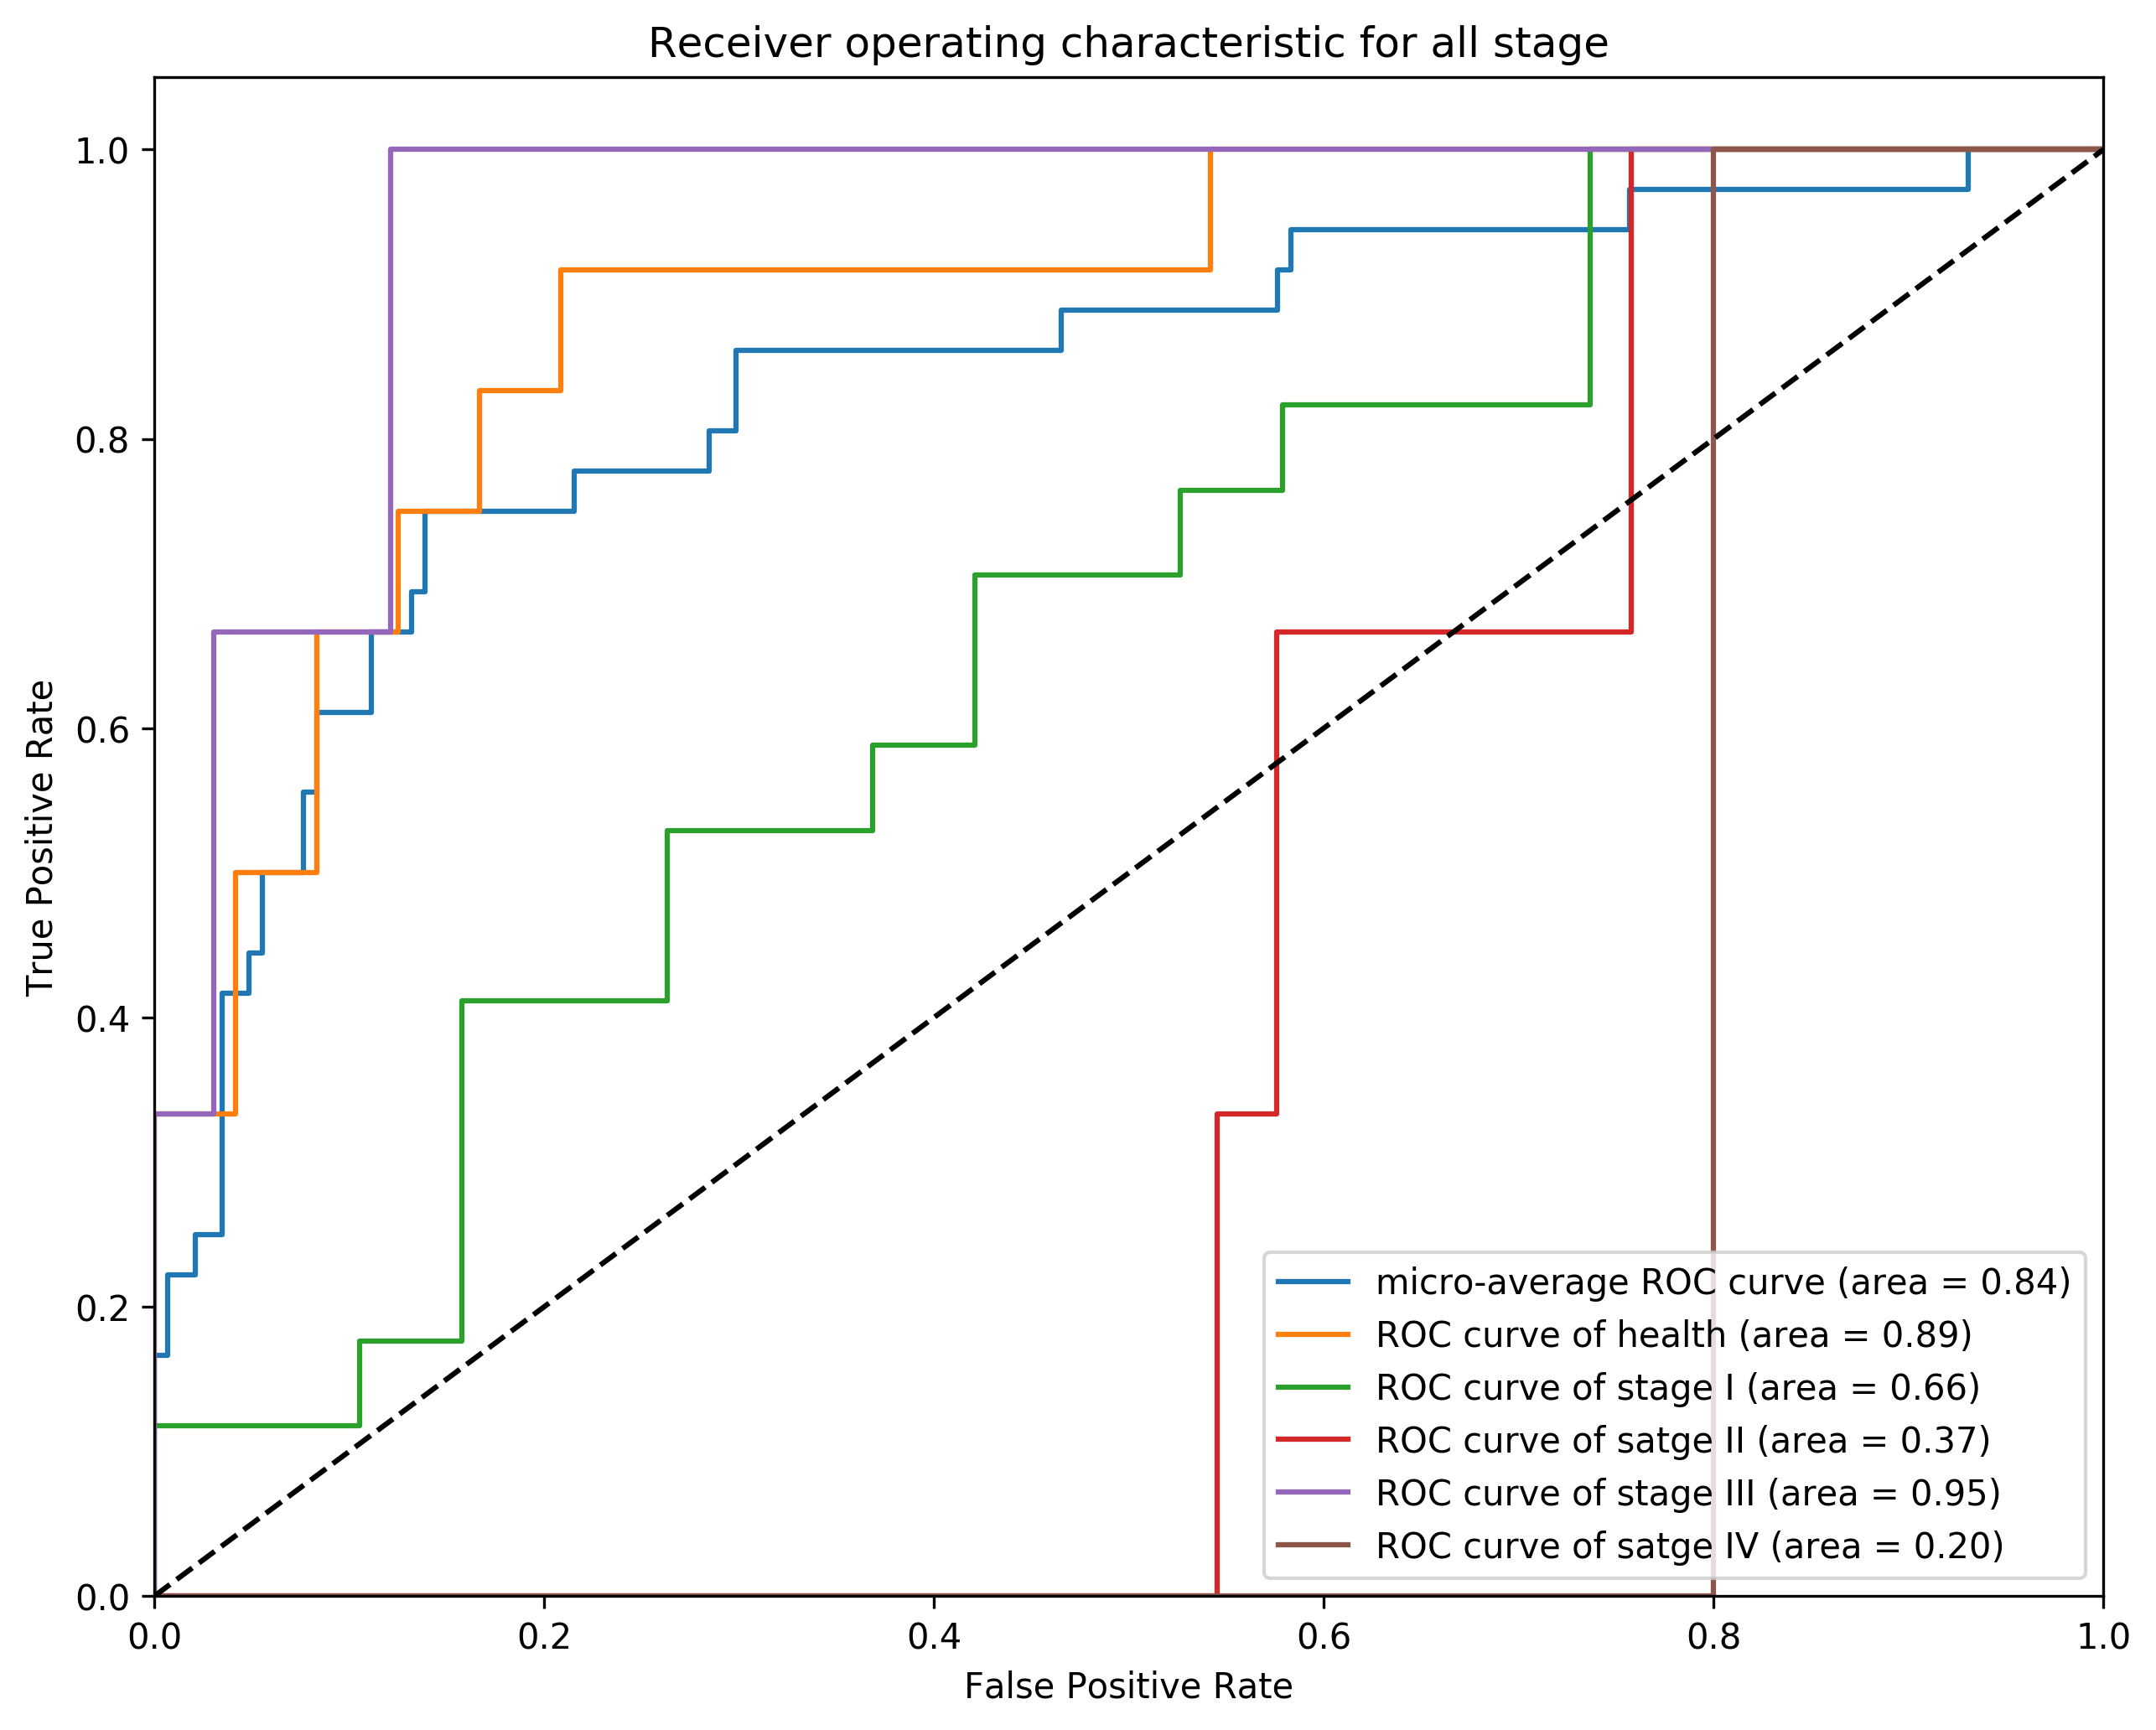

In [14]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(10, 8), dpi=300)
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 8), dpi=300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

class_lab = {0:'health', 1:'stage I', 2: 'satge II', 3: 'stage III', 4: 'satge IV'}
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'
                                   ''.format(class_lab[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for all stage')
plt.legend(loc="lower right")
plt.show()

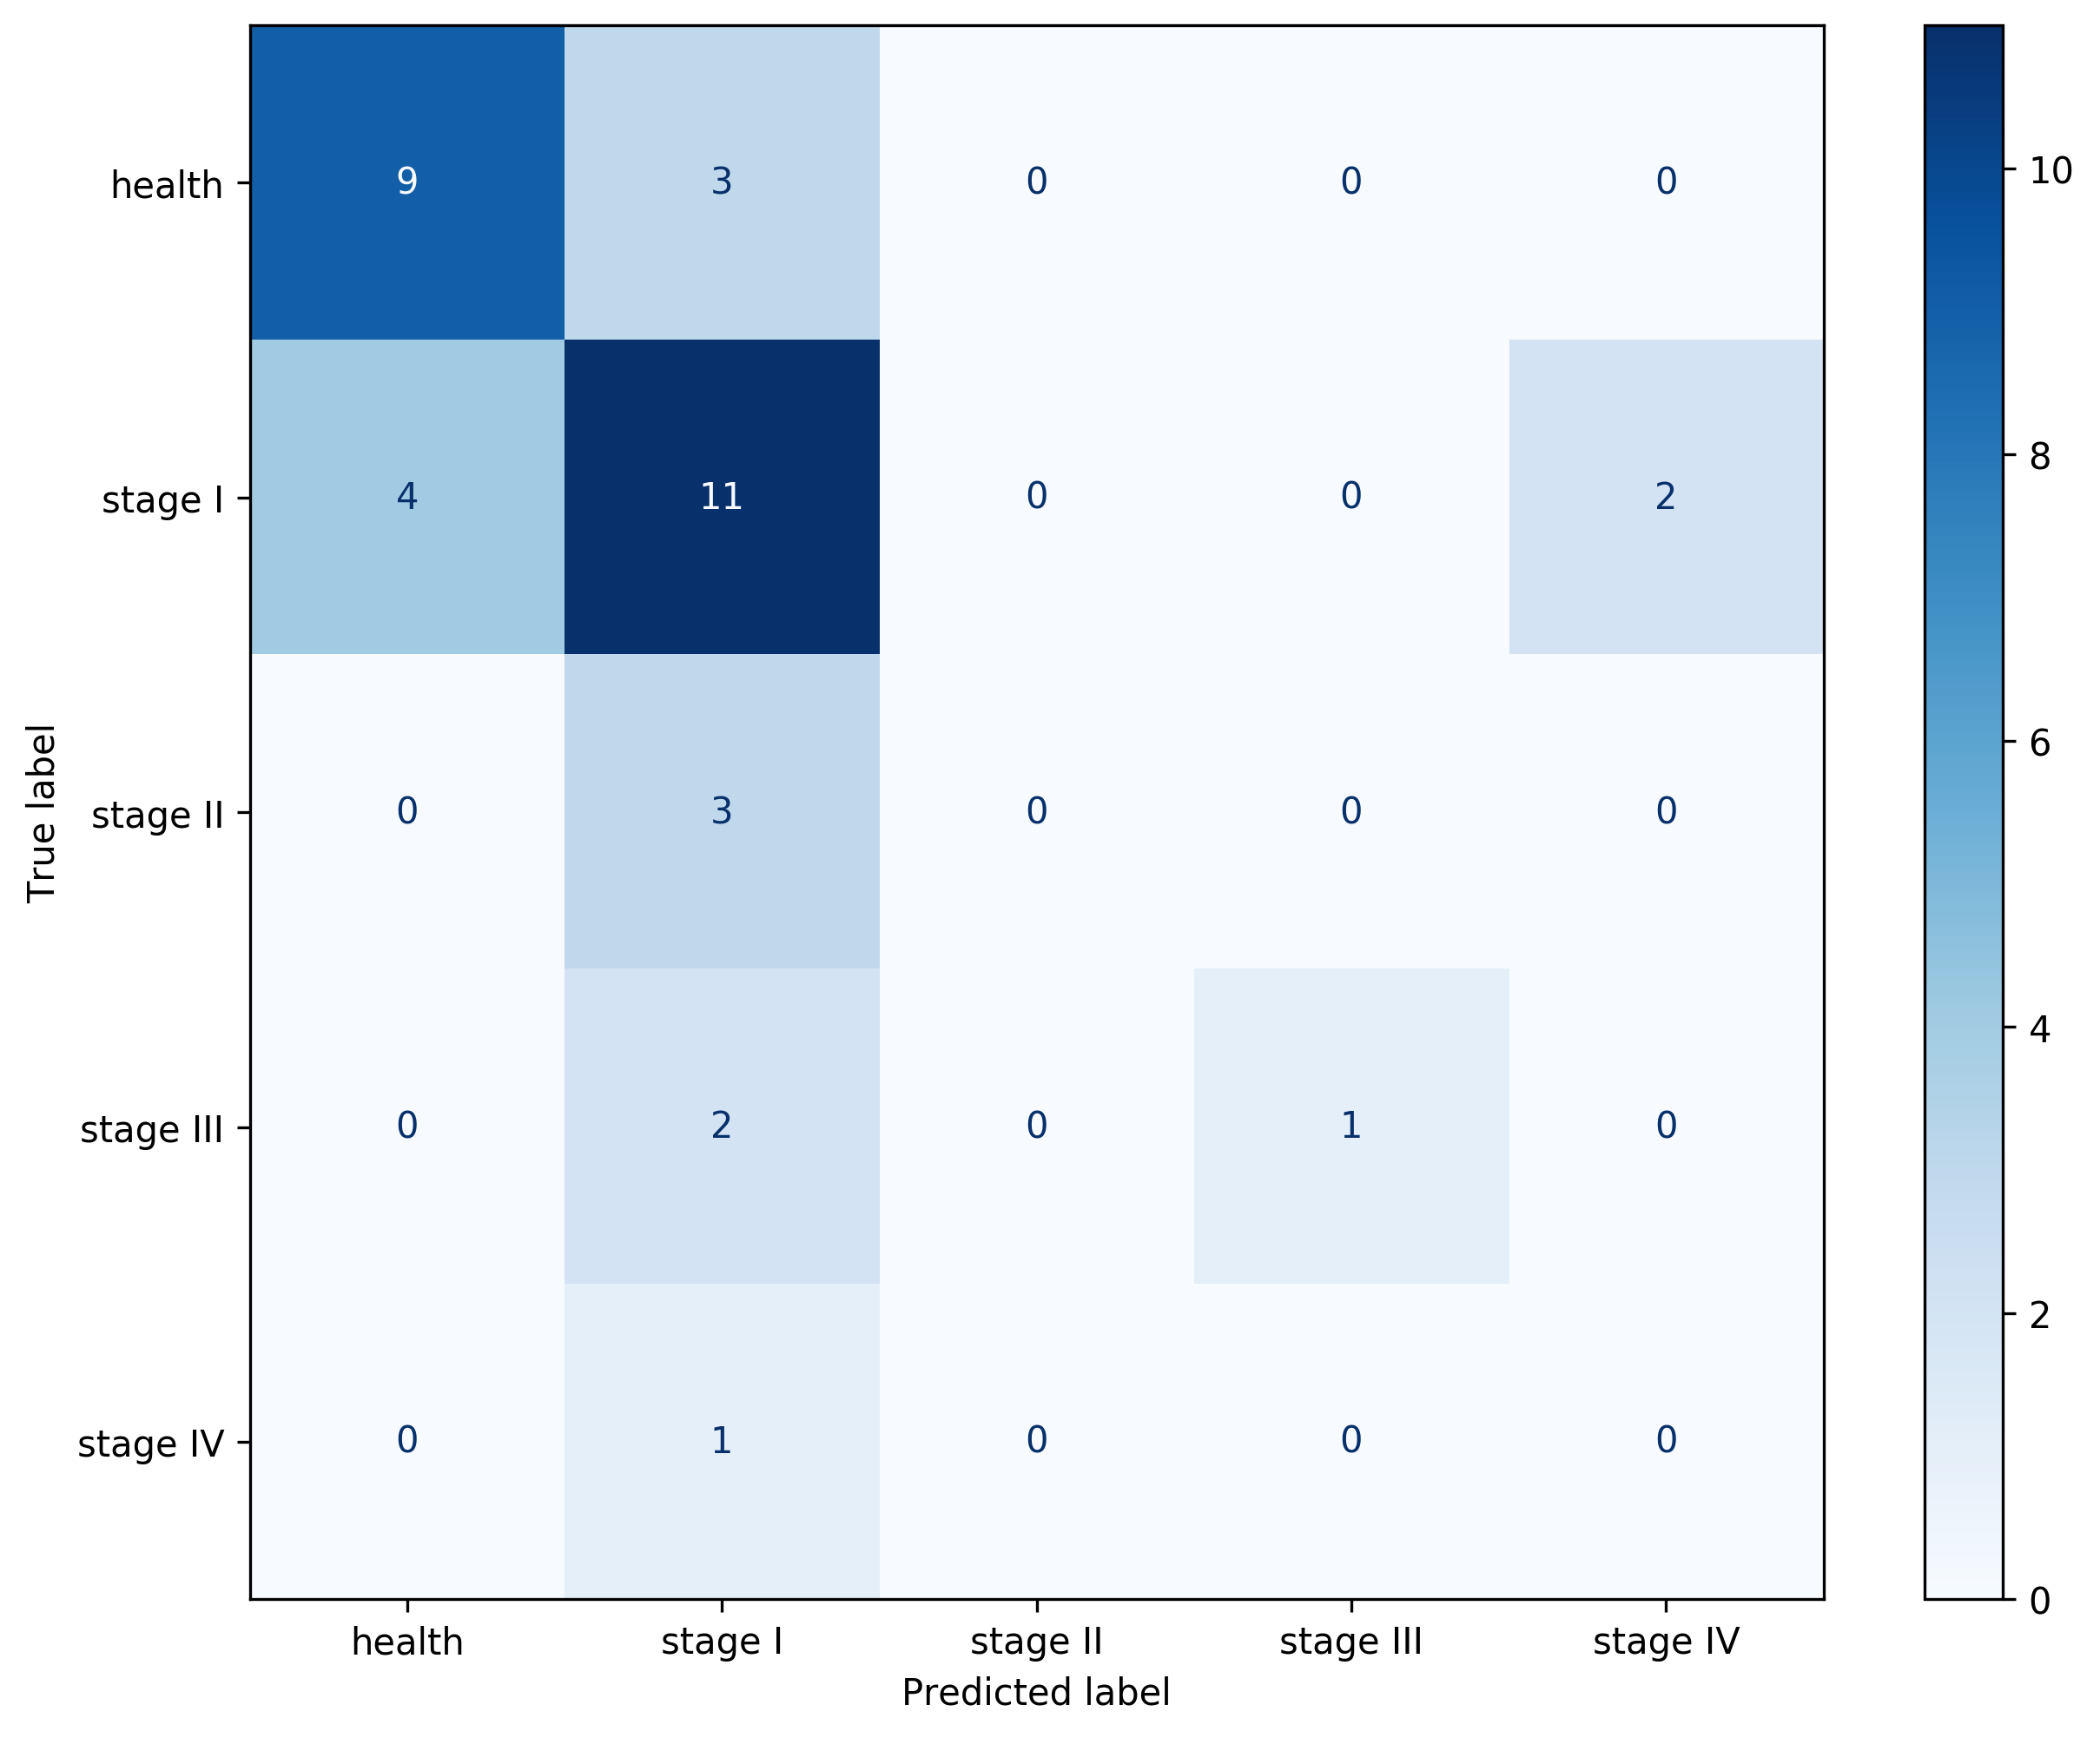

In [15]:

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
disp = plot_confusion_matrix(clf, x_test_new, y_test,
                                 display_labels=['health', 'stage I', 'stage II', 'stage III', 'stage IV'],
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax)

In [16]:
from pycm import ConfusionMatrix
confusion_matrix1 = ConfusionMatrix(y_test, p_pred_lab)
print(confusion_matrix1)

Predict  0        1        2        3        4        
Actual
0        9        3        0        0        0        

1        4        11       0        0        2        

2        0        3        0        0        0        

3        0        2        0        1        0        

4        0        1        0        0        0        





Overall Statistics : 

95% CI                                                            (0.42228,0.74438)
ACC Macro                                                         0.83333
AUNP                                                              0.65125
AUNU                                                              0.60329
Bennett S                                                         0.47917
CBA                                                               0.31513
Chi-Squared                                                       None
Chi-Squared DF                                                    16
Conditional Entropy                  

# Predict all data(train_test)

In [18]:
# load data
from preprocess import load_data, data_split_transform, data_whole_transform, feature_sel
x, y_label, _, y_stage_val, feat_name = load_data('train_data')

In [19]:
model_dir = conf['model_path']['out_model_dir']
def get_data_model(model_type, x):
    # transform using split trained scaler
    if model_type == 'split_train':
        conf_scaler_section = 'model_split_scaler_file'
        conf_sel_feat_section = 'model_split_select_feature_results'
        conf_model_section = 'model_split_model_dump_file'
    else:
        conf_scaler_section = 'model_whole_scaler_file'
        conf_sel_feat_section = 'model_whole_select_feature_results'
        conf_model_section = 'model_whole_model_dump_file'
        
    scaler_fname = os.path.join(model_dir, conf['model_path'][conf_scaler_section])
    scaler = joblib.load(scaler_fname)
    x_s_test = scaler.transform(x)
    
    # load split feature selection
    sel_feat_fname = os.path.join(model_dir, conf['model_path'][conf_sel_feat_section])
    sel_feats_f = np.load(sel_feat_fname)
    raw_feats, sel_supp = sel_feats_f['original_feat'], sel_feats_f['supp']
    
    # load model
    model_fname = os.path.join(model_dir, conf['model_path'][conf_model_section])
    clf = joblib.load(model_fname)
    
    return x_s_test, raw_feats, sel_supp, clf

In [20]:
x_s_test, raw_feats, sel_supp, clf = get_data_model('split_train', x)
x_s_test_new = x_s_test[:, sel_supp]

In [21]:
y_pred = clf.predict_proba(x_s_test_new)

print(list(zip(y_stage_val, y_pred)))

[(0, array([0.32023366, 0.21826762, 0.21950912, 0.1638248 , 0.07816479])), (3, array([0.03705495, 0.12773745, 0.06886241, 0.57786338, 0.18848181])), (0, array([0.61313729, 0.12587544, 0.07486088, 0.06550928, 0.12061711])), (4, array([0.06682158, 0.10144844, 0.05289633, 0.09909618, 0.67973748])), (0, array([0.51957734, 0.17231823, 0.13575863, 0.11919675, 0.05314904])), (3, array([0.07413876, 0.14206404, 0.08714168, 0.61215874, 0.08449678])), (2, array([0.1175016 , 0.31740404, 0.11044161, 0.2327842 , 0.22186855])), (0, array([0.51688716, 0.19016011, 0.08444667, 0.08280694, 0.12569912])), (0, array([0.67012515, 0.10966001, 0.13698697, 0.04635153, 0.03687633])), (0, array([0.4256591 , 0.15065651, 0.25713857, 0.10723761, 0.05930821])), (0, array([0.51349582, 0.1667489 , 0.18219164, 0.09066039, 0.04690325])), (1, array([0.10157958, 0.34249897, 0.13688298, 0.15945357, 0.25958489])), (4, array([0.0732172 , 0.15129313, 0.07905264, 0.145149  , 0.55128802])), (0, array([0.68697568, 0.11282005, 0.